## Load Data

In [1]:
# Basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Other
#import scipy.stats as stats
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

#Algorithms
from sklearn import ensemble, tree, svm, naive_bayes, neighbors, linear_model, gaussian_process, neural_network
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

# Model
from sklearn.metrics import accuracy_score, f1_score, auc, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score

#System
import os
import warnings

#Configure Defaults
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
#pd.set_option('display.max_columns', 500)

In [2]:
print(os.listdir("../input"))

['train.csv', 'sample_submission.csv', 'test.csv', 'data_description.txt']


In [3]:
train = pd.read_csv('../input/train.csv')
train.shape

(1460, 81)

In [4]:
test = pd.read_csv('../input/test.csv')
test.shape

(1459, 80)

In [5]:
desc = open('../input/data_description.txt', 'r')
print(desc.read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [6]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

### Target distribution

In [8]:
# Target variable
sns.distplot(train['SalePrice'], fit=stats.norm)

NameError: name 'stats' is not defined

The target variable is somewhat skewed to the right.

In [9]:
# Correct the skew
train.SalePrice = np.log1p(train.SalePrice)

In [10]:
# Check target distribution
sns.distplot(train['SalePrice'], fit=stats.norm)

NameError: name 'stats' is not defined

Now the variable is normally distributed as the models likes.

## Data Pre-processing

### Concat datasets

In [11]:
# Save test ID
test_ID = test['Id']

# Save train target
target = train.SalePrice.values

# Get split marker
split = len(train)

# Concate data
data = pd.concat((train, test)).reset_index(drop=True)

# Drop index
data.drop("Id", axis=1, inplace=True)

# Drop target column
data.drop("SalePrice", axis=1, inplace=True)

# Check
data.shape

(2919, 79)

### Remove outliers

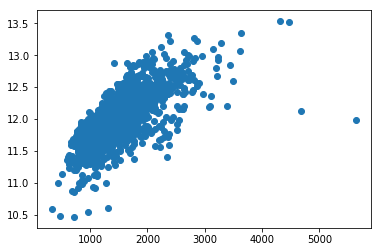

In [12]:
plt.scatter(train.GrLivArea, train.SalePrice)

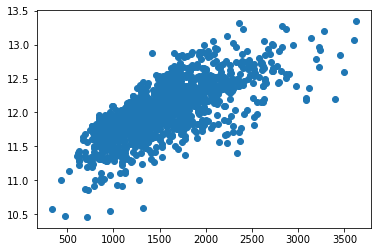

In [13]:
train = train[train.GrLivArea < 4000]
plt.scatter(train.GrLivArea, train.SalePrice)

We'll leave other outliers in the traning dataset as they might be present in the test data as well. Instead, we'll focus on making the model more robust.

### Missing data

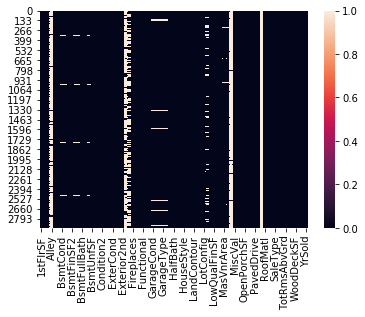

In [14]:
sns.heatmap(data.isnull())

In [15]:
na = data.isnull().sum() / len(data) * 100
na.sort_values(ascending=False).head(10)

PoolQC         99.657
MiscFeature    96.403
Alley          93.217
Fence          80.439
FireplaceQu    48.647
LotFrontage    16.650
GarageFinish    5.447
GarageQual      5.447
GarageYrBlt     5.447
GarageCond      5.447
dtype: float64

In [16]:
features = data

# Some of the non-numeric predictors are stored as numbers; we convert them into strings 
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

features['Functional'] = features['Functional'].fillna('Typ')
features['Electrical'] = features['Electrical'].fillna("SBrkr")
features['KitchenQual'] = features['KitchenQual'].fillna("TA")
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

features["PoolQC"] = features["PoolQC"].fillna("None")

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')

features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)

features.update(features[objects].fillna('None'))

features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# Filling in the rest of the NA's

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics2.append(i)

skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

features = features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])

# simplified features
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

data = features

In [17]:
'''# Drop mostly empty features
data = data.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis = 1)'''

"# Drop mostly empty features\ndata = data.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis = 1)"

In [18]:
'''# Set None = NAN for the feature
data['FireplaceQu'].replace('None', np.nan, inplace=True)

# Create boolean flag for roughly 50% NAs
data["FireplaceQu_Flag"] = data["FireplaceQu"].notnull().astype('int')

# Drop original
data = data.drop(['FireplaceQu'], axis = 1)'''

'# Set None = NAN for the feature\ndata[\'FireplaceQu\'].replace(\'None\', np.nan, inplace=True)\n\n# Create boolean flag for roughly 50% NAs\ndata["FireplaceQu_Flag"] = data["FireplaceQu"].notnull().astype(\'int\')\n\n# Drop original\ndata = data.drop([\'FireplaceQu\'], axis = 1)'

In [19]:
'''# Fill median into ~1/6 NAs
data.LotFrontage = data.LotFrontage.fillna(data.LotFrontage.median())'''

'# Fill median into ~1/6 NAs\ndata.LotFrontage = data.LotFrontage.fillna(data.LotFrontage.median())'

In [20]:
'''# Select columns due to theirs data type
float_col = data.select_dtypes('float')
int_col = data.select_dtypes('int')
object_col = data.select_dtypes('object')'''

"# Select columns due to theirs data type\nfloat_col = data.select_dtypes('float')\nint_col = data.select_dtypes('int')\nobject_col = data.select_dtypes('object')"

In [21]:
'''# Remove and impute numerical features
for f in float_col: data[f] = data[f].fillna(data[f].median())
   #if data[f].isnull().sum() / data.shape[0] > 0.1667: del data[f] # Remove 1/6+ of NANs
   #else: data[f] = data[f].fillna(data[f].mean()) # Impute others with a mean value'''

'# Remove and impute numerical features\nfor f in float_col: data[f] = data[f].fillna(data[f].median())\n   #if data[f].isnull().sum() / data.shape[0] > 0.1667: del data[f] # Remove 1/6+ of NANs\n   #else: data[f] = data[f].fillna(data[f].mean()) # Impute others with a mean value'

In [22]:
'''# Remove and impute numerical features
for i in int_col: data[i] = data[i].fillna(data[i].mode()[0])
   #if data[i].isnull().sum() / data.shape[0] > 0.1667: del data[f] # Remove 1/6+ of NANs
   #else: data[i] = data[i].fillna(data[i].mode()[0]) # Impute others with a mean value'''

'# Remove and impute numerical features\nfor i in int_col: data[i] = data[i].fillna(data[i].mode()[0])\n   #if data[i].isnull().sum() / data.shape[0] > 0.1667: del data[f] # Remove 1/6+ of NANs\n   #else: data[i] = data[i].fillna(data[i].mode()[0]) # Impute others with a mean value'

In [23]:
'''for o in object_col: data[o] = data[o].fillna('Unknown')'''

"for o in object_col: data[o] = data[o].fillna('Unknown')"

### Feature engineering

In [24]:
'''# These are actually categorical
num_cat = ['MSSubClass', 'OverallCond', 'YrSold', 'MoSold']
data[num_cat] = data[num_cat].astype(str)'''

"# These are actually categorical\nnum_cat = ['MSSubClass', 'OverallCond', 'YrSold', 'MoSold']\ndata[num_cat] = data[num_cat].astype(str)"

In [25]:
'''# Create new features
data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']

data['Total_sqr_footage'] = (data['BsmtFinSF1'] + data['BsmtFinSF2'] +
                                 data['1stFlrSF'] + data['2ndFlrSF'])

data['Total_Bathrooms'] = (data['FullBath'] + (0.5*data['HalfBath']) + 
                               data['BsmtFullBath'] + (0.5*data['BsmtHalfBath']))

data['Total_porch_sf'] = (data['OpenPorchSF'] + data['3SsnPorch'] +
                              data['EnclosedPorch'] + data['ScreenPorch'] +
                             data['WoodDeckSF'])'''

"# Create new features\ndata['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']\n\ndata['Total_sqr_footage'] = (data['BsmtFinSF1'] + data['BsmtFinSF2'] +\n                                 data['1stFlrSF'] + data['2ndFlrSF'])\n\ndata['Total_Bathrooms'] = (data['FullBath'] + (0.5*data['HalfBath']) + \n                               data['BsmtFullBath'] + (0.5*data['BsmtHalfBath']))\n\ndata['Total_porch_sf'] = (data['OpenPorchSF'] + data['3SsnPorch'] +\n                              data['EnclosedPorch'] + data['ScreenPorch'] +\n                             data['WoodDeckSF'])"

In [26]:
'''# Create boolean flags
data['Pool_Flag'] = data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
data['2ndfloor_Flag'] = data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
data['Garage_Flag'] = data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
data['Bsmt_Flag'] = data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
data['Fireplace_Flag'] = data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)'''

"# Create boolean flags\ndata['Pool_Flag'] = data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)\ndata['2ndfloor_Flag'] = data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)\ndata['Garage_Flag'] = data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)\ndata['Bsmt_Flag'] = data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)\ndata['Fireplace_Flag'] = data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)"

### Skewed features

In [27]:
'''num_f = data.dtypes[data.dtypes != "object"].index

# Check the skew of all numerical features
skew_f = data[num_f].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skew = pd.DataFrame({'Skew' :skew_f})
skew.head(10)'''

'num_f = data.dtypes[data.dtypes != "object"].index\n\n# Check the skew of all numerical features\nskew_f = data[num_f].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)\nskew = pd.DataFrame({\'Skew\' :skew_f})\nskew.head(10)'

### Box Cox transformation

In [28]:
'''from scipy.special import boxcox1p

skew = skew[abs(skew) > 0.5]
print("There are {} skewed numerical features to Box Cox transform".format(skew.shape[0]))

skew_f = skew.index
lam = 0.15
for f in skew_f:
    #all_data[feat] += 1
    data[f] = boxcox1p(data[f], lam)'''

'from scipy.special import boxcox1p\n\nskew = skew[abs(skew) > 0.5]\nprint("There are {} skewed numerical features to Box Cox transform".format(skew.shape[0]))\n\nskew_f = skew.index\nlam = 0.15\nfor f in skew_f:\n    #all_data[feat] += 1\n    data[f] = boxcox1p(data[f], lam)'

### Feature Encoding

In [29]:
data = pd.get_dummies(data, prefix_sep='_', drop_first=True) # Drop originall feature to avoid multi-collinearity

In [30]:
data.shape

(2919, 291)

In [31]:
# Remove high-variance features
'''from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(data)''' # Array is the output

'from sklearn.feature_selection import VarianceThreshold\nsel = VarianceThreshold(threshold=(.8 * (1 - .8)))\nsel.fit_transform(data)'

In [32]:
# TODO: feature selection

In [33]:
data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageArea,GarageCars,GarageYrBlt,GrLivArea,HalfBath,KitchenAbvGr,LotArea,LotFrontage,LowQualFinSF,MasVnrArea,MiscVal,OpenPorchSF,OverallCond,OverallQual,PoolArea,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrBltAndRemod,TotalSF,Total_sqr_footage,Total_Bathrooms,Total_porch_sf,haspool,has2ndfloor,...,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,PavedDrive_P,PavedDrive_Y,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,5.318,1019.541,0.000,3,117.856,0.000,0.993,0.000,30.017,0.000,0.000,2,548.000,2.000,2003.000,7.234,1.069,0.751,13.425,14.664,0.000,19.379,0.000,12.010,3.990,7,0.000,0.000,2.238,296.832,0.000,2003,2003,4006,1321.691,1142.715,3.527,12.010,0,1,...,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0
1,5.551,0.000,0.000,3,146.806,0.000,0.000,0.711,44.179,0.000,0.901,2,460.000,2.000,1976.000,6.947,0.000,0.751,13.695,16.495,0.000,0.000,0.000,0.000,5.996,6,0.000,0.000,1.978,407.302,56.339,1976,1976,3952,412.853,152.356,2.355,56.339,0,0,...,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0
2,5.362,1034.306,0.000,3,91.575,0.000,0.993,0.000,56.958,0.000,0.901,2,608.000,2.000,2001.000,7.275,1.069,0.751,14.034,15.045,0.000,17.721,0.000,9.849,3.990,7,0.000,0.000,1.978,314.805,0.000,2001,2002,4003,1354.473,1131.244,3.527,9.849,0,1,...,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0
3,5.388,899.201,0.000,3,52.776,0.000,0.993,0.000,64.882,16.012,0.901,1,642.000,3.000,1998.000,7.238,0.000,0.751,13.683,14.008,0.000,0.000,0.000,8.922,3.990,7,0.000,0.000,2.116,268.234,0.000,1915,1970,3885,1172.823,957.365,1.993,24.934,0,1,...,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,5.493,1265.168,0.000,4,112.040,0.000,0.993,0.000,61.234,0.000,0.901,2,836.000,3.000,2000.000,7.471,1.069,0.751,14.550,16.954,0.000,25.323,0.000,14.180,3.990,8,0.000,0.000,2.348,376.259,42.351,2000,2000,4000,1646.920,1382.701,3.527,56.532,0,1,...,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0


### Split data

In [34]:
# Split data
train = data[:split]
test = data[split:]

# Get train variables for a model
x = train
y = target

# Train data split
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.22, random_state=101)

### Model

In [35]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

from mlxtend.regressor import StackingCVRegressor

In [36]:
#Validation function
n_folds = 5

def rmsle_cv(model, X, y):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X)
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

### Define algorithms

In [37]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [38]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [39]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [40]:
#svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [41]:
XGB = xgb.XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

In [42]:
LGBM = lgb.LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

In [43]:
stack = StackingCVRegressor(regressors=(KRR, lasso, ENet, XGB, LGBM),
                                meta_regressor=XGB,
                                use_features_in_secondary=True)

### Score Algorithms

In [44]:
models = [KRR, lasso, ENet, XGB, LGBM]

for m in models:
    score = rmsle_cv(m, X_train, y_train)
    print("Model score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Model score: 0.2578 (0.0119)

Model score: 0.1222 (0.0100)

Model score: 0.1225 (0.0100)

[13:13:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model score: 0.1247 (0.0100)

Model score: 0.1233 (0.0108)



### Train

In [45]:
models.append(stack)

for m in models:
    m.fit(X_train, y_train)

[13:14:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:14:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [46]:
'''print('START Fit')

print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))'''

"print('START Fit')\n\nprint('stack_gen')\nstack_gen_model = stack_gen.fit(np.array(X), np.array(y))"

In [47]:
def assembly(X):
    result = 0
    for m in models:
        result += m.predict(X) 
    return result / len(models) # Avg predict value of all models

In [48]:
def assembly(X):
    return ((0.1 * KRR.predict(X)) + \
            (0.1 * lasso.predict(X)) + \
            (0.1 * ENet.predict(X)) + \
            (0.1 * XGB.predict(X)) + \
            (0.1 * LGBM.predict(X)) + \
            (0.5 * stack.predict(np.array(X))))

In [49]:
'''print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))'''

"print('RMSLE score on train data:')\nprint(rmsle(y, blend_models_predict(X)))"

In [50]:
print('RMSLE score on train data:')
print(rmsle(y_train, assembly(X_train)))

RMSLE score on train data:
0.05396646964351222


In [51]:
pred = np.floor(np.expm1(assembly(test)))

In [52]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = pred
sub.to_csv('submission.csv',index=False)

In [53]:
sub.head()

,Id,SalePrice
0,1461,125385.000
1,1462,160084.000
2,1463,189581.000
3,1464,203142.000
4,1465,186154.000
